In [96]:
import sys  
sys.path.insert(0, r'C:\Users\marci\Desktop\Python\Numba-tutorial')
import numpy as np
import math
import matplotlib.pyplot as plt
from numba import int64, int32, float64, float32, cuda, guvectorize

In [76]:
from codes.FractionalAbundance import FractionalAbundance

### Example of CUDA Fractional Abundance 

In [77]:
FA = FractionalAbundance(element="Ar", concurrent=True)

### K matrix

In [78]:
K = FA.K

In [79]:
K.shape

(19, 800, 100)

### Calculation with NumPy

In [80]:
K_cumprod = np.cumprod(K, axis=0)

In [81]:
K_cumprod.shape

(19, 800, 100)

In [82]:
K_cumprod_sum = np.sum(K_cumprod, axis=0)

In [83]:
FA_numpy = np.divide(K_cumprod, K_cumprod_sum)

In [84]:
FA_numpy.shape

(19, 800, 100)

In [85]:
def calculate_FA_numpy(K):
    K_cumprod = np.cumprod(K, axis=0)
    K_cumprod_sum = np.sum(K_cumprod, axis=0)
    return np.divide(K_cumprod, K_cumprod_sum)

In [86]:
FA_numpy = calculate_FA_numpy(K)

In [87]:
%timeit calculate_FA_numpy(K)

12.6 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


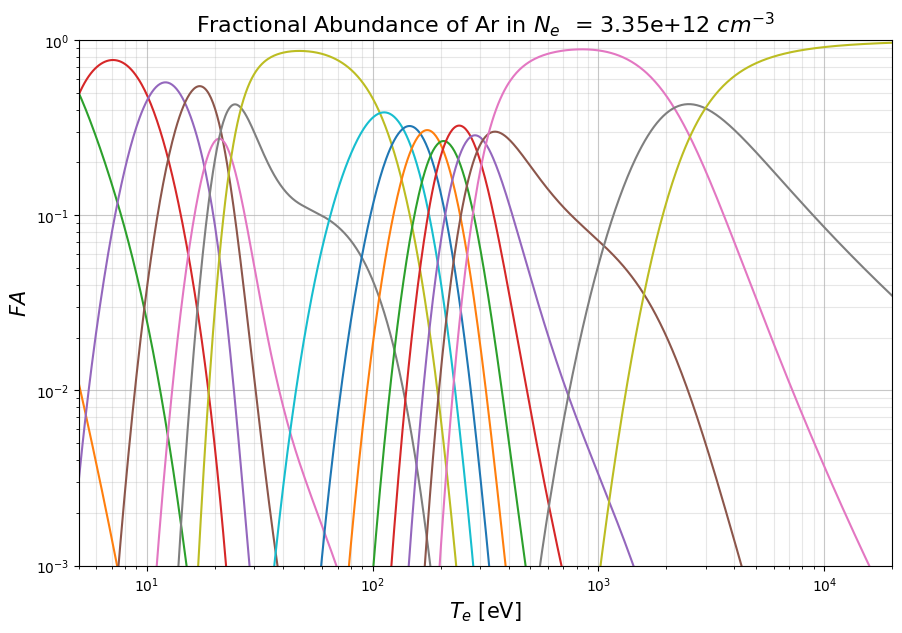

In [88]:
for ion in range(0, FA.Z+1):
    plt.plot(FA.Te_new, FA_numpy[ion, : ,50])
    
plt.title("Fractional Abundance of " + FA.element + " in $N_{e}$  = " + "{:.2e}".format(FA.Ne_new[50]) + " $cm^{-3}$",fontsize=16)
plt.xlabel("$T_{e}$ [eV]", fontsize=15)
plt.ylabel("$FA$", fontsize=15)
plt.xscale("log")
plt.yscale("log")
plt.ylim((10**-3, 10**0))
plt.xlim((5, 20000))
plt.minorticks_on()
plt.grid(which='minor', alpha=0.3)
plt.grid(which='major', alpha=0.7)

### Calculation with loops

In [89]:
def calculate_FA_loops(K):
    FA_output = np.zeros_like(K)
    for i in range(K.shape[1]):
        for j in range(K.shape[2]):
            sum_all = 0.0
            current_product = 1.0
            product_all = []
            for k in range(K.shape[0]):
                current_product *= K[k,i,j]
                sum_all += current_product
                product_all.append(current_product)
            for k in range(K.shape[0]):    
                  FA_output[k,i,j] = product_all[k]/sum_all
    return FA_output

In [90]:
FA_output = calculate_FA_loops(K)

In [95]:
%timeit calculate_FA_loops(K)

670 ms ± 6.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Calculation with Numba CUDA

In [111]:
array = K.copy()

In [112]:
threadsperblock = (FA.Z+1, 5, 5)
blockspergrid_x = math.ceil(array.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(array.shape[1] / threadsperblock[1])
blockspergrid_z = math.ceil(array.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

In [113]:
print(f"Threads per block: {threadsperblock}")
print(f"Blocks per grid: {blockspergrid}")
print(f"Input array shape: {array.shape}")
print(threadsperblock[0]*threadsperblock[1]*threadsperblock[2] < 1024)
print(array.shape[0] == threadsperblock[0]*blockspergrid[0])
print(array.shape[1] == threadsperblock[1]*blockspergrid[1])
print(array.shape[2] == threadsperblock[2]*blockspergrid[2])

Threads per block: (19, 5, 5)
Blocks per grid: (1, 160, 20)
Input array shape: (19, 800, 100)
True
True
True
True


In [114]:
@cuda.jit('void(float64[:,:,:], float64[:,:,:])')
def calculate_FA_gpu(X,Y):
    k, j, i = cuda.grid(3)
    if i < X.shape[2] and j < X.shape[1] and k < X.shape[0]:
        sum_all = 0
        current_product = 1
        for k in range(X.shape[0]):
            current_product *= X[k, j, i]
            sum_all += current_product
            Y[k, j, i] = current_product
            if k == X.shape[0] - 1:
                for k in range(X.shape[0]):
                    Y[k, j, i] = Y[k, j, i] / sum_all
                    cuda.syncthreads()


In [115]:
# device array
device_array = cuda.to_device((array).astype(np.float64))
# result array
result_array = cuda.device_array_like(np.ones_like(array).astype(np.float64))
# calculate
calculate_FA_gpu[blockspergrid, threadsperblock](device_array, result_array)
# copy result
result_gpu = result_array.copy_to_host()

In [127]:
import time
start = time.time()
calculate_FA_gpu[blockspergrid, threadsperblock](device_array, result_array)
end = time.time()
print((end-start)*1000.0)

0.9992122650146484


In [128]:
%timeit calculate_FA_gpu[blockspergrid, threadsperblock](device_array, result_array)

6.74 ms ± 19.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Tests

In [27]:
np.random.seed(1)
array_random = np.random.rand(3,2,1)
array_random

array([[[4.17022005e-01],
        [7.20324493e-01]],

       [[1.14374817e-04],
        [3.02332573e-01]],

       [[1.46755891e-01],
        [9.23385948e-02]]])

In [28]:
array = np.insert(array_random,[0],[1,1]).reshape(4,2,1)
array

array([[[1.00000000e+00],
        [1.00000000e+00]],

       [[4.17022005e-01],
        [7.20324493e-01]],

       [[1.14374817e-04],
        [3.02332573e-01]],

       [[1.46755891e-01],
        [9.23385948e-02]]])

In [29]:
array[1][1][0]

0.7203244934421581

In [30]:
def multidim_cumsum(array,sums=False):
    array_out = []
    for i in range(array.shape[1]):
        for j in range(array.shape[2]):
            if sums:
                array_out.append(np.cumprod(array[:,i,j])/np.cumprod(array[:,i,j]).sum())
            else:
                array_out.append(np.cumprod(array[:,i,j]))
    return np.array(array_out).T.reshape(4,2,1)

In [31]:
multidim_cumsum(array)

array([[[1.00000000e+00],
        [1.00000000e+00]],

       [[4.17022005e-01],
        [7.20324493e-01]],

       [[4.76968156e-05],
        [2.17777557e-01]],

       [[6.99978866e-06],
        [2.01092736e-02]]])

In [32]:
array.shape

(4, 2, 1)

In [33]:
array[0, 1, 0]

1.0

In [34]:
threadsperblock = (2, 2, 1)
blockspergrid_x = math.ceil(array.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(array.shape[1] / threadsperblock[1])
blockspergrid_z = math.ceil(array.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
print('blocks',blockspergrid)
print('threads',threadsperblock)
print(array.shape)

blocks (2, 1, 1)
threads (2, 2, 1)
(4, 2, 1)


In [35]:
from numba import cuda
import math 
from numba import float32 
@cuda.jit()
def cum_prod(X,Y):
    cuda.syncthreads()
    k, j, i = cuda.grid(3)
    if i < X.shape[2] and j < X.shape[1] and k < X.shape[0]:
        current_product = 1
        sum_all = 0
        for k in range(X.shape[0]):
            current_product *= X[k,j,i]
            Y[k, j, i] = current_product
            sum_all += current_product
            cuda.syncthreads()
            if k == (X.shape[0] - 1):
                for k in range(X.shape[0]):
                    Y[k, j, i] = Y[k, j, i] / sum_all

In [36]:
# X array
device_array = cuda.to_device((array).astype(np.float32))
# Y array
result_array = cuda.device_array_like(device_array)

cum_prod[blockspergrid, threadsperblock](device_array, result_array)
cuda.synchronize()
result_gpu = result_array.copy_to_host()
result_gpu

C:\Users\marci\AppData\Roaming\Python\Python39\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([[[7.0567811e-01],
        [5.1067013e-01]],

       [[2.9428330e-01],
        [3.6784819e-01]],

       [[3.3658598e-05],
        [1.1121249e-01]],

       [[4.9395971e-06],
        [1.0269205e-02]]], dtype=float32)

In [37]:
np.array_equal(result_gpu, multidim_cumsum(array,sums=True))

False

In [38]:
np.allclose(result_gpu, multidim_cumsum(array,sums=True))

True

In [39]:
multidim_cumsum(array,sums=True)

array([[[7.05678104e-01],
        [5.10670114e-01]],

       [[2.94283298e-01],
        [3.67848191e-01]],

       [[3.36585984e-05],
        [1.11212490e-01]],

       [[4.93959759e-06],
        [1.02692050e-02]]])

In [40]:
cuda.detect()

Found 1 CUDA devices
id 0          b'NVIDIA T500'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-18c0c16d-d4f9-016a-277e-948d06a0c634
                                Watchdog: Enabled
                            Compute Mode: WDDM
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True